# Загрузка данных и предобработка

In [10]:
# !pip install natasha
# !pip install razdel

In [2]:
import os
os.chdir('/content')

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import re
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, Reshape, Dense, Dropout, BatchNormalization, Flatten, SimpleRNN, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model


from razdel import tokenize
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    NamesExtractor,
    Doc
)

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data1 = pd.read_excel('rbc_01.05.2024_15.05.2024.xlsx')
data2 = pd.read_excel('rbc_16.05.2024_31.05.2024.xlsx')
data3 = pd.read_excel('rbc_01.04.2024_20.04.2024.xlsx')

data = pd.concat([data1, data2, data3], ignore_index=True) # Объединение файлов

In [5]:
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
# Найдем индексы строк, где значение в колонке 'category' равно 'Политика'
politika_indices = pd.DataFrame(data[data['category'] == 'Политика'].index)

# Выберем случайную половину из найденных индексов
random_politika_indices = politika_indices.sample(frac=0.5, random_state=42)

# Удалим строки с выбранными индексами
data = data.drop(index=random_politika_indices[0].values)

Посмотрим на долю категорий. Категория "политика" преобладает, что может создать проблемы в будущем.

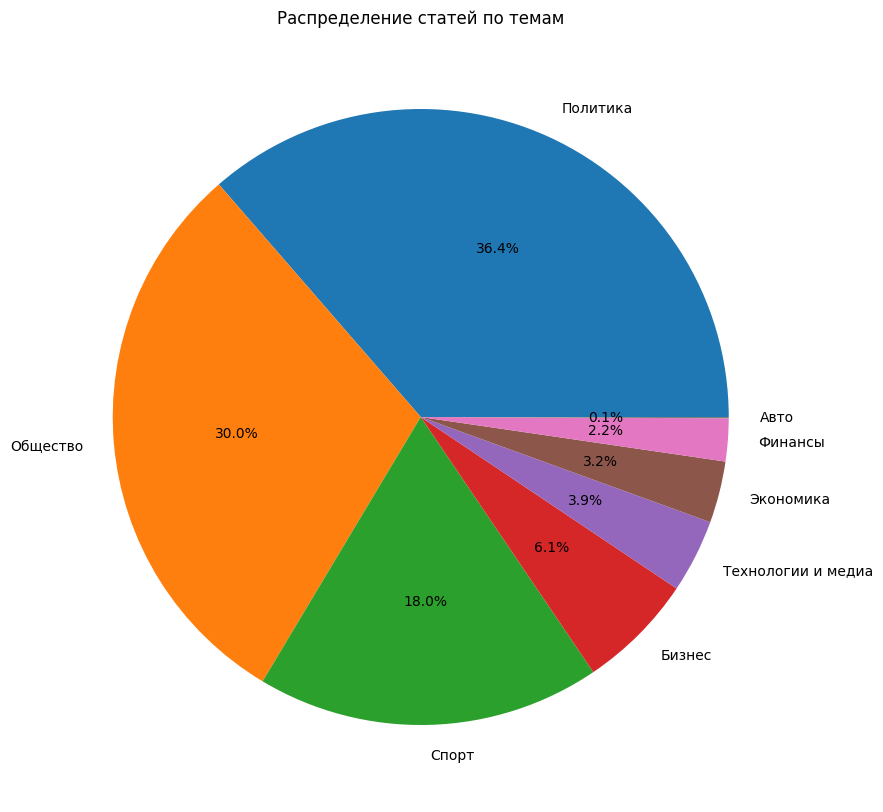

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(data['category'].value_counts(), labels=data['category'].value_counts().index, autopct='%1.1f%%')
ax.set_title("Распределение статей по темам")
plt.show()

In [8]:
data['category'].value_counts()

category
Политика              2171
Общество              1793
Спорт                 1077
Бизнес                 366
Технологии и медиа     230
Экономика              193
Финансы                134
Авто                     4
Name: count, dtype: int64

In [9]:
Data = data[['category', 'text']]
Data = Data[Data['category'] != 'Авто']

In [10]:
Data.shape

(5967, 2)

In [11]:
category_counts = Data['category'].value_counts()
CLASS_LIST = category_counts.index.tolist()

In [12]:
# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)
print(CLASS_LIST)

['Политика', 'Общество', 'Спорт', 'Бизнес', 'Технологии и медиа', 'Экономика', 'Финансы']


Определим обучающую и тестовую выборки

In [115]:
# Перемешиваем данные
data_shuffled = shuffle(Data)

# Разделение данных на train_data и test_data
train_data, test_data = train_test_split(data_shuffled, test_size=0.15, random_state=42)

# Вывод информации о размерах train_data и test_data
print("Размер train_data:", train_data.shape)
print("Размер test_data:", test_data.shape)

Размер train_data: (5071, 2)
Размер test_data: (896, 2)


In [116]:
train_data.head(1)

,category,text
8077,Бизнес,Ассоциация компаний интернет-торговли (АКИТ) п...


In [127]:
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    if isinstance(text, str):
        # Приведение текста к нижнему регистру
        text = text.lower()
        # Удаление пунктуации
        text = re.sub(r'[^\w\s]', '', text)
        # Токенизация текста
        tokens = word_tokenize(text)
        # Удаление стоп-слов
        tokens = [word for word in tokens if word not in stop_words]
        return tokens
    else:
        return []

# Применение предобработки к тексту в DataFrame
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [129]:
# Задание параметров преобразования
VOCAB_SIZE = 20000
WIN_SIZE = 1000
WIN_HOP = 100

In [130]:
# train_data['text'] = train_data['text'].astype(str)
# test_data['text'] = test_data['text'].astype(str)
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_data['text'])

In [131]:
# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())
words = [word for word, index in items]

# Вывод нескольких наиболее часто встречающихся слов
print(words[:120])
print("Размер словаря", len(words))

['видео', 'время', 'года', 'июне', 'пмэф', 'рбк', 'заявил', 'который', 'глава', 'страны', '2024', 'связи', 'ес', 'москвы', 'москве', 'нато', 'назвал', 'вместе', 'пять', '100', 'произошло', 'две', 'мид', 'стало', 'россией', 'россии', 'войск', 'войны', 'производство', 'турции', 'известно', 'центре', 'попал', 'акции', 'вместо', 'правительстве', 'какие', 'прошла', 'telegram', 'выйти', 'земли', 'лукашенко', 'случай', 'недвижимости', 'италии', 'автобуса', 'вина', 'класса', 'обстрел', 'здании', 'самые', '2024го', 'главных', 'путиным', 'холдинга', 'ответили', 'мирового', 'курс', 'отправки', 'брюсселе', 'брикс', 'ремонта', 'президенты', 'жкх', 'обрушилась', 'рубль', 'евро2024', 'вступить', 'выступят', 'желании', 'петербург', 'маршрутов', 'доллара', 'изменится', 'разработало', 'лука', 'законах', 'забастовка', 'фразой', 'фаворитов', 'выглядят', 'фермеров', 'монголии', 'проверенными', 'видеокадры', 'макрону', 'рухнули', 'шахта', 'суперкомпьютер', 'диапазона', 'запланировал', 'галактики', 'новостям

In [102]:
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [132]:
# Проверка индекса слова в словаре
try:
    print('Интересующее слово имеет индекс:', tokenizer.word_index[input('Введите слово: ')])
except:
    print('Интересующего вас слова нет в словаре')


Введите слово: рука
Интересующее слово имеет индекс: 36384


In [133]:
seq_train = tokenizer.texts_to_sequences(train_data['text'])
seq_test = tokenizer.texts_to_sequences(test_data['text'])

print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", train_data['text'][1][:101])
print("Он же в виде последовательности индексов: ", seq_test[:20])


Фрагмент обучающего текста:
В виде оригинального текста:               ['служба', 'безопасности', 'украины', 'сбу', 'использовала', 'подрыва', 'крымского', 'моста', 'октябре', '2022', 'года', 'самодельное', 'взрывное', 'устройство', 'мощностью', 'эквивалентной', '10', 'тоннам', 'тротила', 'говорится', 'выводах', 'взрывотехнической', 'экспертизы', 'пишет', 'коммерсантъ', 'основным', 'зарядом', 'стало', 'смесевое', 'взрывчатое', 'вещество', 'основе', 'твердого', 'ракетного', 'топлива', 'содержащего', 'перхлораты', 'калия', 'натрия', 'также', 'мелкодисперсные', 'металлы', 'заключили', 'эксперты', 'версии', 'самодельную', 'бомбу', 'спрятали', 'полиэтиленовой', 'пленкой', 'толщиной', '01', 'мм', 'плотный', 'слой', 'стал', 'оболочкой', 'устройства', 'сказано', 'заключении', 'экспертов', 'возбуждения', 'детонации', 'применили', 'зарубежное', 'взрывчатое', 'вещество', 'основе', 'гексогена', 'скорее', 'c4', 'pe8', 'спрятанный', 'пленкой', 'детонатор', 'сработал', 'сигнала', 'gpsнавигатора', 'мо

In [134]:
x_train_seq_len = []
for i in seq_train:
    x_train_seq_len.append(len(i))

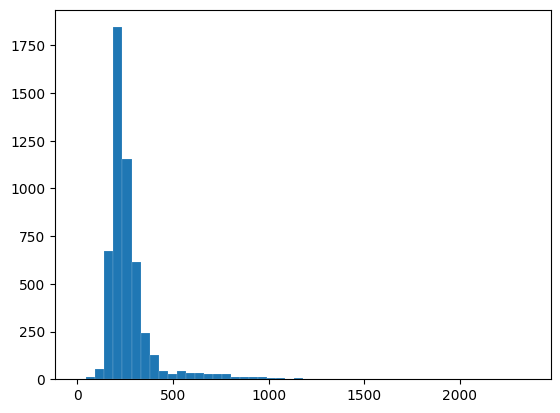

In [141]:
# Как правило, большинство имеет менее 500 токенов
fig, ax = plt.subplots()
ax.hist(x_train_seq_len, bins=50, linewidth=0.1, edgecolor="white")
plt.show()

In [136]:
len_max = 500

In [137]:
x_train = pad_sequences(seq_train, maxlen=len_max)
x_test = pad_sequences(seq_test, maxlen=len_max)

In [138]:
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist(), mode='tfidf')
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist(), mode='tfidf')

In [139]:
x_train_01[0].shape

(20000,)

In [142]:
# Преобразование меток в one-hot encoding
y_train_classes = pd.get_dummies(train_data['category']).astype(int)   # преобразуем метки из обучающей выборки в one-hot encoding
y_train = np.array(y_train_classes.values.tolist())   # преобразуем one-hot encoding в numpy-массив

y_test_classes = pd.get_dummies(test_data['category']).astype(int)   # преобразуем метки из тестовой выборки в one-hot encoding
y_test = np.array(y_test_classes.values.tolist())   # преобразуем one-hot encoding в numpy-массив

In [143]:
print(f'Величина тренировочной выборки: {len(y_train)}')
print(f'Величина тестовой выборки: {len(y_test)}')

Величина тренировочной выборки: 5071
Величина тестовой выборки: 896


In [144]:
# учтем веса
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

In [145]:
class_weights

{0: 2.3368663594470047,
 1: 0.48263062720091365,
 2: 0.38718790562724287,
 3: 0.7874223602484473,
 4: 3.753515914137676,
 5: 6.354636591478696,
 6: 4.4717813051146384}

In [146]:
# Проверка количества уникальных классов в обучающем и тестовом наборах
num_classes_train = y_train.shape[1]
num_classes_test = y_test.shape[1]

print(f"Количество классов в y_train: {num_classes_train}")
print(f"Количество классов в y_test: {num_classes_test}")

# Проверка количества классов в данных
unique_classes_train = train_data['category'].nunique()
unique_classes_test = test_data['category'].nunique()

print(f"Количество уникальных классов в train_data: {unique_classes_train}")
print(f"Количество уникальных классов в test_data: {unique_classes_test}")

Количество классов в y_train: 7
Количество классов в y_test: 7
Количество уникальных классов в train_data: 7
Количество уникальных классов в test_data: 7


# Функция

In [151]:
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=30,
                        batch_size=128,
                        figsize=(20, 5)):


    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    checkpoint = ModelCheckpoint(f'{model}_weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks = [early_stopping, checkpoint],
                        class_weight=class_weights)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):

    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')


    for cls in range(len(class_labels)):
        cls_pred = np.argmax(cm[cls])
        #
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('

        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=30,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

## Simple BoW

In [100]:
# Создание последовательной модели нейросети
model_text_bow_softmax = Sequential()
model_text_bow_softmax.add(Dense(200, input_dim=VOCAB_SIZE, activation="relu"))
model_text_bow_softmax.add(Dropout(0.25))
model_text_bow_softmax.add(BatchNormalization())
model_text_bow_softmax.add(Dense(CLASS_COUNT, activation='softmax'))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               4000200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 4002407 (15.27 MB)
Trainable params: 4002007 (15.27 MB)
Non-trainable params: 400 (1.56 KB)
_________________________________________________________________
Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 1.1988 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9552
Epoch 2: val_loss improved from 0.51017 to 0.43134, saving model to <keras.src.engine.sequential.Sequential object at 0x7eb41c2ff670>_weights.hdf5
33/33 [==============================] - 4s 125ms/step - loss: 0.1125 - accuracy: 0.9552 - val_loss: 0.4313 - val_accuracy: 0.8786
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9913
Epoch 3: val_loss did not improve from 0.43134
33/33 [==============================] - 5s 150ms/step - loss: 0.0389 - accuracy: 0.9913 - val_loss: 0.4415 - val_accuracy: 0.8759
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9969
Epoch 4: val_loss improved from 0.43134 to 0.43101, saving model to <keras.src.engine.sequential.Sequential object at 0x7eb41c2ff670>_weights.hdf5
33/33 [==============================] - 4s 132ms/step - loss: 0.0182 - accuracy: 0.9969 - val_loss: 0.4310 - val_accuracy: 0.

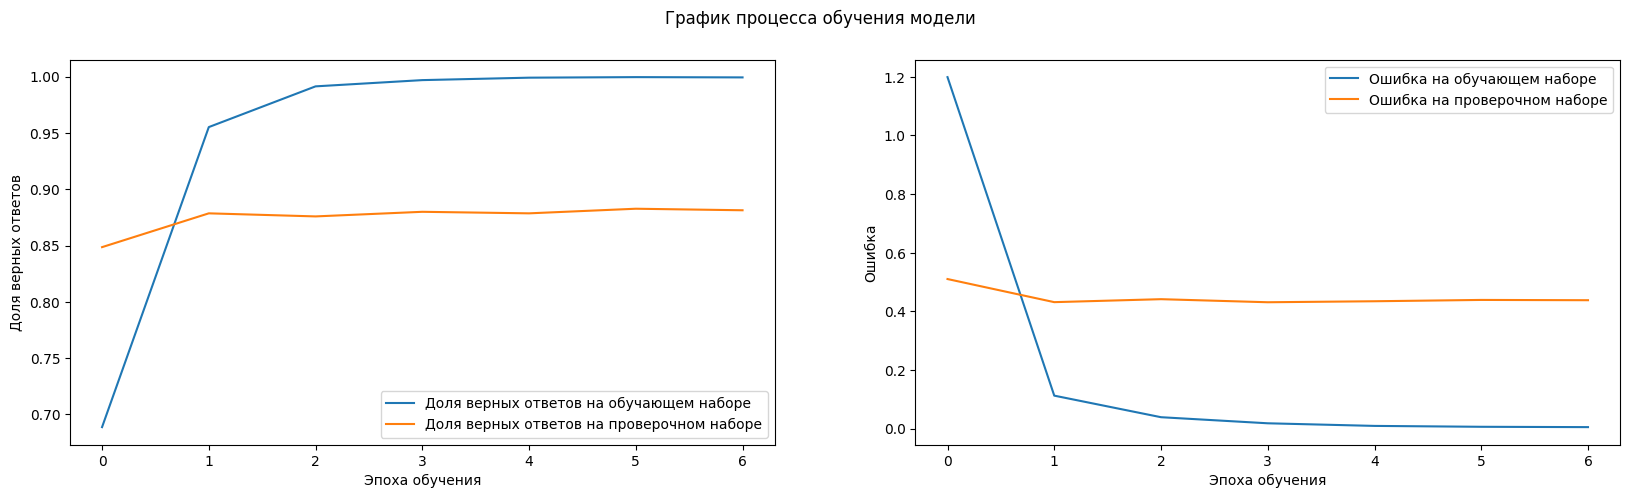

23/23 [==============================] - 1s 22ms/step


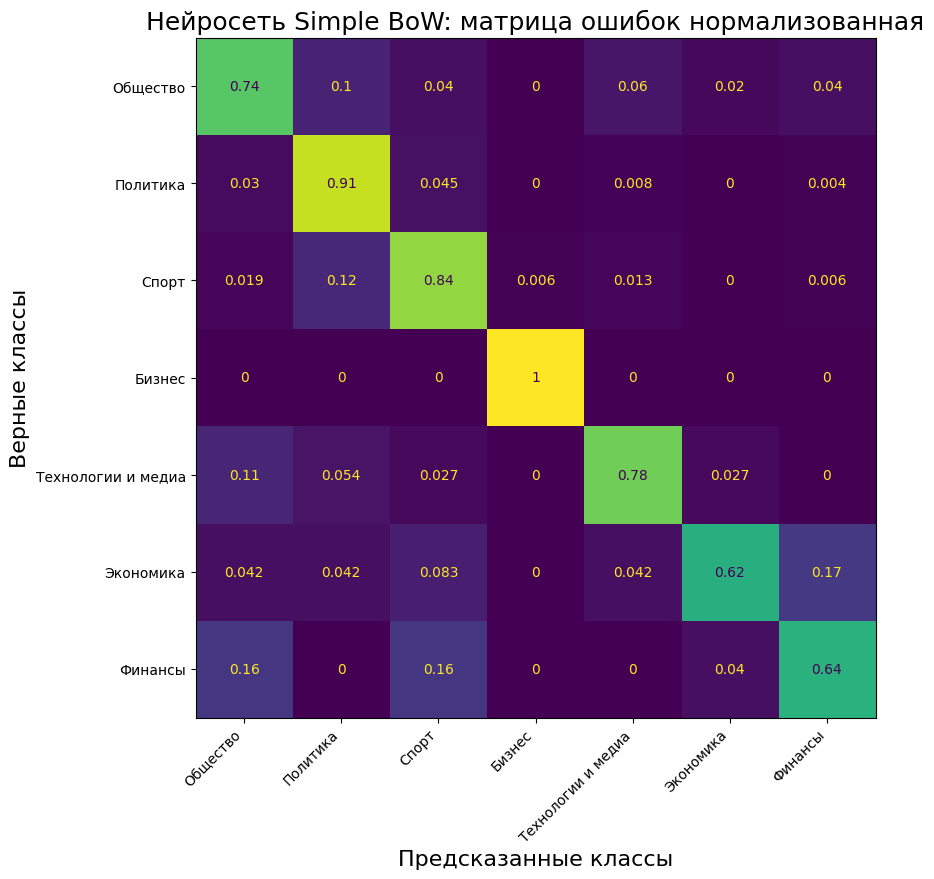

----------------------------------------------------------------------------------------------------
Нейросеть: Simple BoW
Класс: Общество              74% сеть отнесла к классу Общество             - ВЕРНО :-)
Класс: Политика              91% сеть отнесла к классу Политика             - ВЕРНО :-)
Класс: Спорт                 84% сеть отнесла к классу Спорт                - ВЕРНО :-)
Класс: Бизнес               100% сеть отнесла к классу Бизнес               - ВЕРНО :-)
Класс: Технологии и медиа    78% сеть отнесла к классу Технологии и медиа   - ВЕРНО :-)
Класс: Экономика             62% сеть отнесла к классу Экономика            - ВЕРНО :-)
Класс: Финансы               64% сеть отнесла к классу Финансы              - ВЕРНО :-)

Средняя точность распознавания:  79%


In [101]:
# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_softmax,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='Simple BoW')


## Conv1D BoW

In [102]:
# Создание модели
model_conv_bow = Sequential()
model_conv_bow.add(Dense(512, input_dim=VOCAB_SIZE, activation="relu"))
model_conv_bow.add(Dropout(0.2))
model_conv_bow.add(Reshape((-1, 512)))
model_conv_bow.add(Conv1D(64, kernel_size=2, activation="relu", padding="same"))
model_conv_bow.add(Flatten())
model_conv_bow.add(BatchNormalization())
model_conv_bow.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               10240512  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 1, 512)            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             65600     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 22s 636ms/step - loss: 1.0582 - accuracy: 0.6953 - val_loss: 0.4541 - val_accuracy: 0.8690
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9540
Epoch 2: val_loss did not improve from 0.45411
33/33 [==============================] - 13s 391ms/step - loss: 0.1309 - accuracy: 0.9540 - val_loss: 0.4626 - val_accuracy: 0.8690
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9937
Epoch 3: val_loss improved from 0.45411 to 0.44293, saving model to <keras.src.engine.sequential.Sequential object at 0x7eb420aa50f0>_weights.hdf5
33/33 [==============================] - 14s 420ms/step - loss: 0.0383 - accuracy: 0.9937 - val_loss: 0.4429 - val_accuracy: 0.8704
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9986
Epoch 4: val_loss did not improve from 0.44293
33/33 [==============================] - 13s 387ms/step - loss: 0.0166 - accuracy

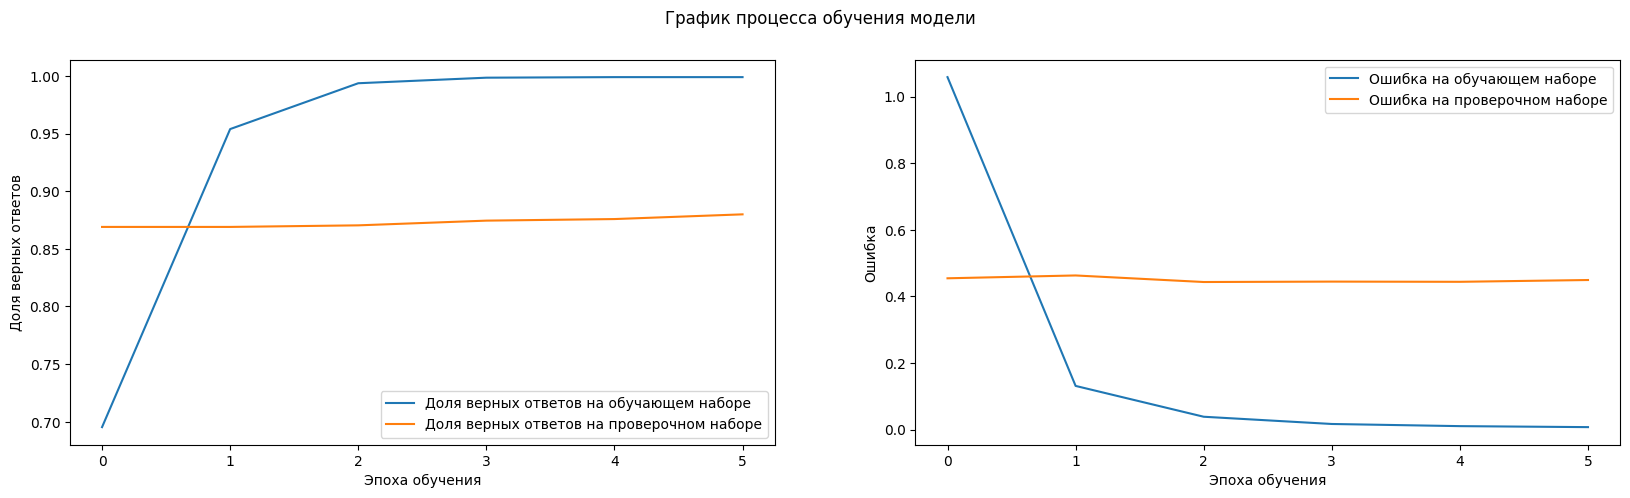

23/23 [==============================] - 1s 27ms/step


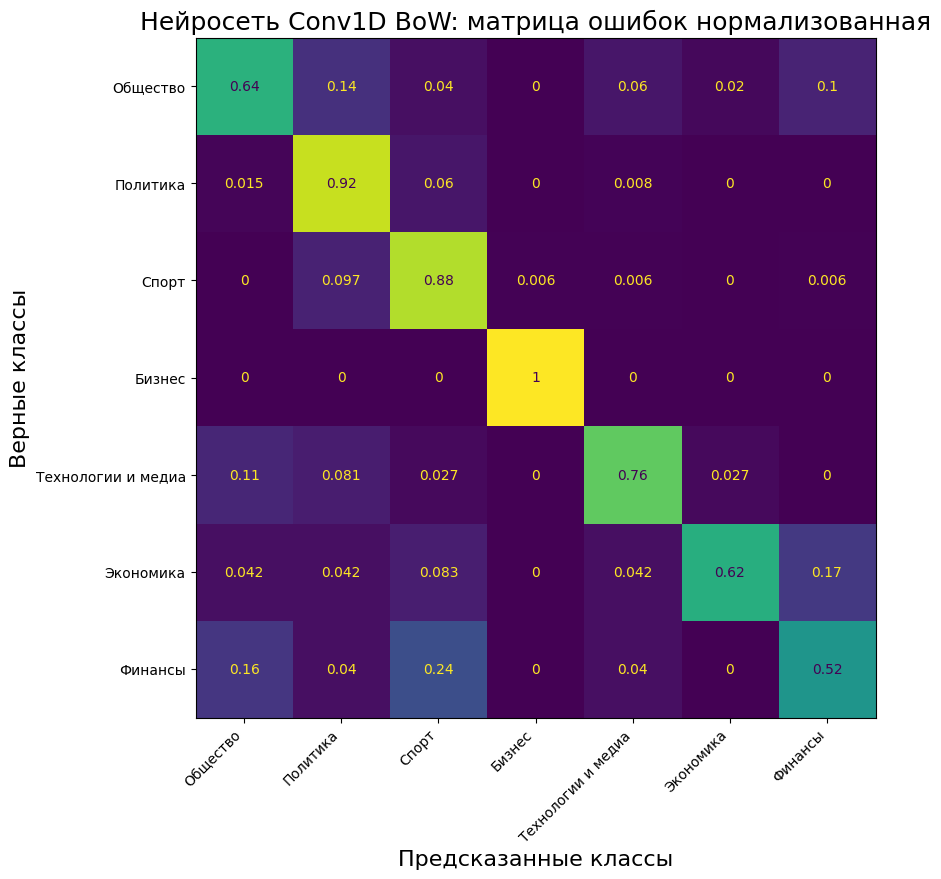

----------------------------------------------------------------------------------------------------
Нейросеть: Conv1D BoW
Класс: Общество              64% сеть отнесла к классу Общество             - ВЕРНО :-)
Класс: Политика              92% сеть отнесла к классу Политика             - ВЕРНО :-)
Класс: Спорт                 88% сеть отнесла к классу Спорт                - ВЕРНО :-)
Класс: Бизнес               100% сеть отнесла к классу Бизнес               - ВЕРНО :-)
Класс: Технологии и медиа    76% сеть отнесла к классу Технологии и медиа   - ВЕРНО :-)
Класс: Экономика             62% сеть отнесла к классу Экономика            - ВЕРНО :-)
Класс: Финансы               52% сеть отнесла к классу Финансы              - ВЕРНО :-)

Средняя точность распознавания:  76%


In [103]:
# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_conv_bow,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='Conv1D BoW')

## RNN BoW

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 512)               10240512  
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 reshape_8 (Reshape)         (None, 1, 512)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               61300     
                                                                 
 dense_40 (Dense)            (None, 7)                 707       
                                                                 
Total params: 10302519 (39.30 MB)
Trainable params: 10302519 (39.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 10s 344ms/step - loss: 1.1807 - accuracy: 0.7010 - val_loss: 0.5770 - val_accuracy: 0.7981
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9700
Epoch 2: val_loss improved from 0.57704 to 0.54198, saving model to <keras.src.engine.sequential.Sequential object at 0x7eeaad760d00>_weights.hdf5
24/24 [==============================] - 7s 275ms/step - loss: 0.0914 - accuracy: 0.9700 - val_loss: 0.5420 - val_accuracy: 0.8286
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9966
Epoch 3: val_loss did not improve from 0.54198
24/24 [==============================] - 8s 320ms/step - loss: 0.0304 - accuracy: 0.9966 - val_loss: 0.5937 - val_accuracy: 0.8171
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9990
Epoch 4: val_loss did not improve from 0.54198
24/24 [==============================] - 6s 244ms/step - loss: 0.0081 - accuracy: 0

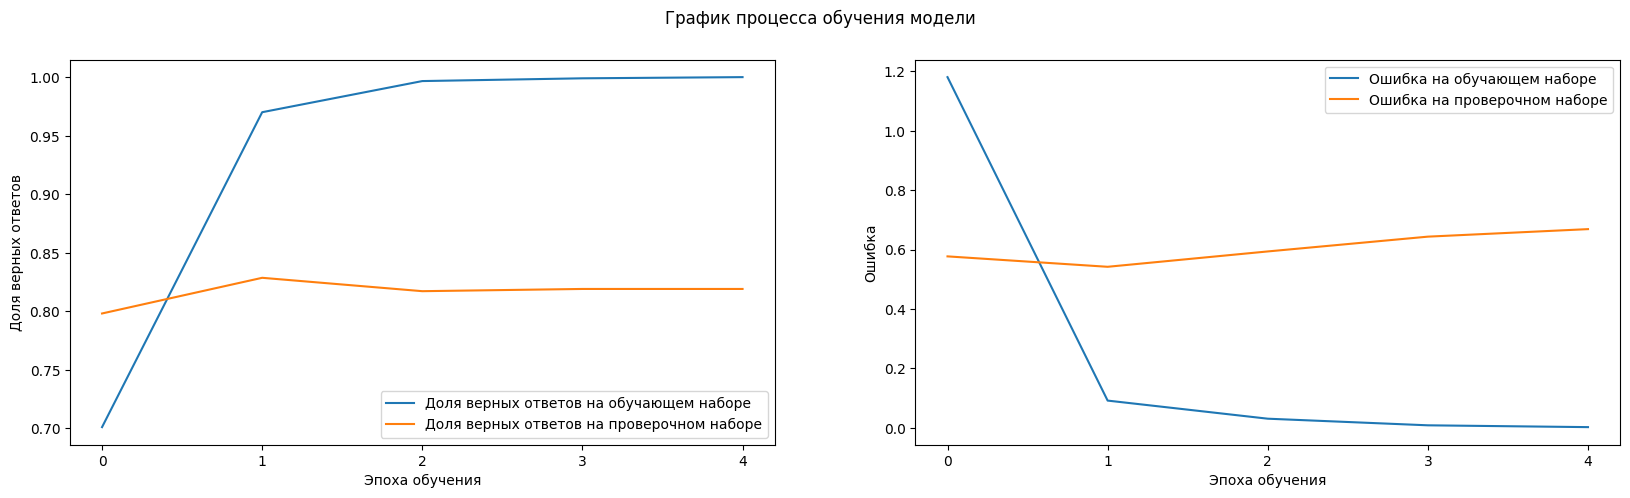

17/17 [==============================] - 1s 26ms/step


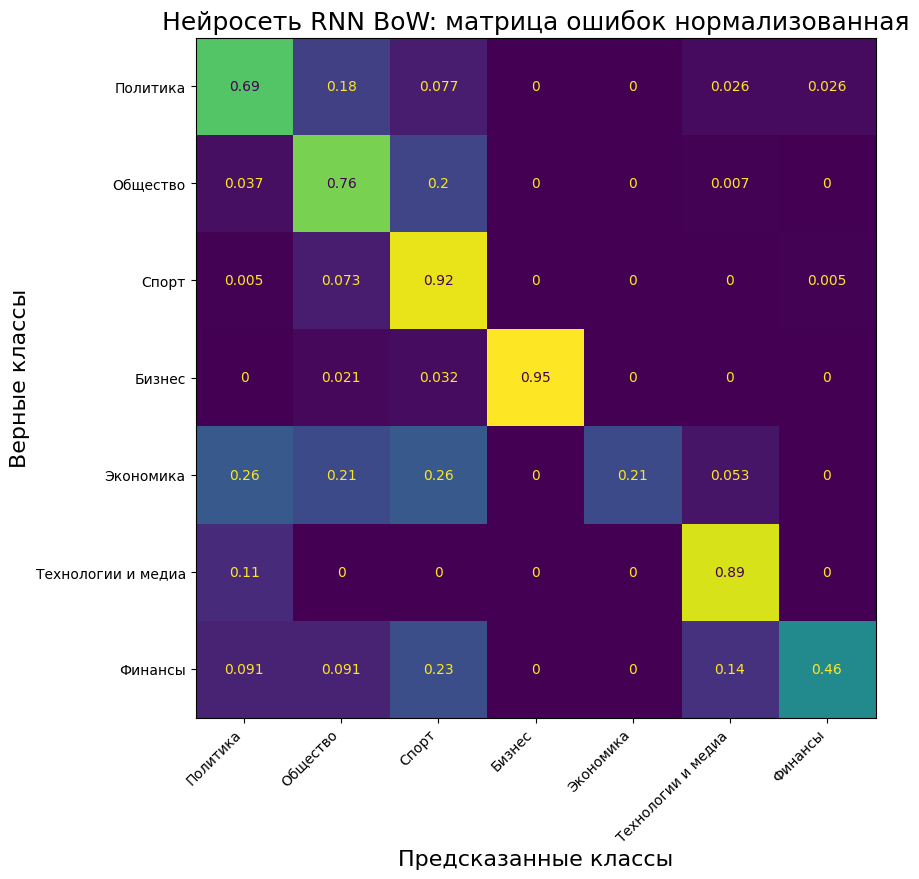

----------------------------------------------------------------------------------------------------
Нейросеть: RNN BoW
Класс: Политика              69% сеть отнесла к классу Политика             - ВЕРНО :-)
Класс: Общество              76% сеть отнесла к классу Общество             - ВЕРНО :-)
Класс: Спорт                 92% сеть отнесла к классу Спорт                - ВЕРНО :-)
Класс: Бизнес                95% сеть отнесла к классу Бизнес               - ВЕРНО :-)
Класс: Экономика             26% сеть отнесла к классу Политика             - НЕВЕРНО :-(
Класс: Технологии и медиа    89% сеть отнесла к классу Технологии и медиа   - ВЕРНО :-)
Класс: Финансы               46% сеть отнесла к классу Финансы              - ВЕРНО :-)

Средняя точность распознавания:  70%


In [303]:
model_rnn_bow_simple = Sequential()
model_rnn_bow_simple.add(Dense(512, input_shape=(VOCAB_SIZE,), activation='relu'))
model_rnn_bow_simple.add(Dropout(0.25))
model_rnn_bow_simple.add(Reshape((-1, 512)))
model_rnn_bow_simple.add(SimpleRNN(100, activation='relu'))
model_rnn_bow_simple.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_rnn_bow_simple,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='RNN BoW')

## Embedding Conv1D

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20000, 256)        256000    
                                                                 
 conv1d (Conv1D)             (None, 19998, 64)         49216     
                                                                 
 dropout (Dropout)           (None, 19998, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1279872)           0         
                                                                 
 dense (Dense)               (None, 7)                 8959111   
                                                                 
Total params: 9264327 (35.34 MB)
Trainable params: 9264327 (35.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
40/40

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 35s 586ms/step - loss: 2.2145 - accuracy: 0.6009 - val_loss: 0.5326 - val_accuracy: 0.8270
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8943
Epoch 2: val_loss improved from 0.53259 to 0.42014, saving model to <keras.src.engine.sequential.Sequential object at 0x7abddd231e40>_weights.hdf5
40/40 [==============================] - 19s 477ms/step - loss: 0.3020 - accuracy: 0.8943 - val_loss: 0.4201 - val_accuracy: 0.8650
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9828
Epoch 3: val_loss improved from 0.42014 to 0.40727, saving model to <keras.src.engine.sequential.Sequential object at 0x7abddd231e40>_weights.hdf5
40/40 [==============================] - 19s 472ms/step - loss: 0.0420 - accuracy: 0.9828 - val_loss: 0.4073 - val_accuracy: 0.8605
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9966
Epoch 4: val_loss did not im

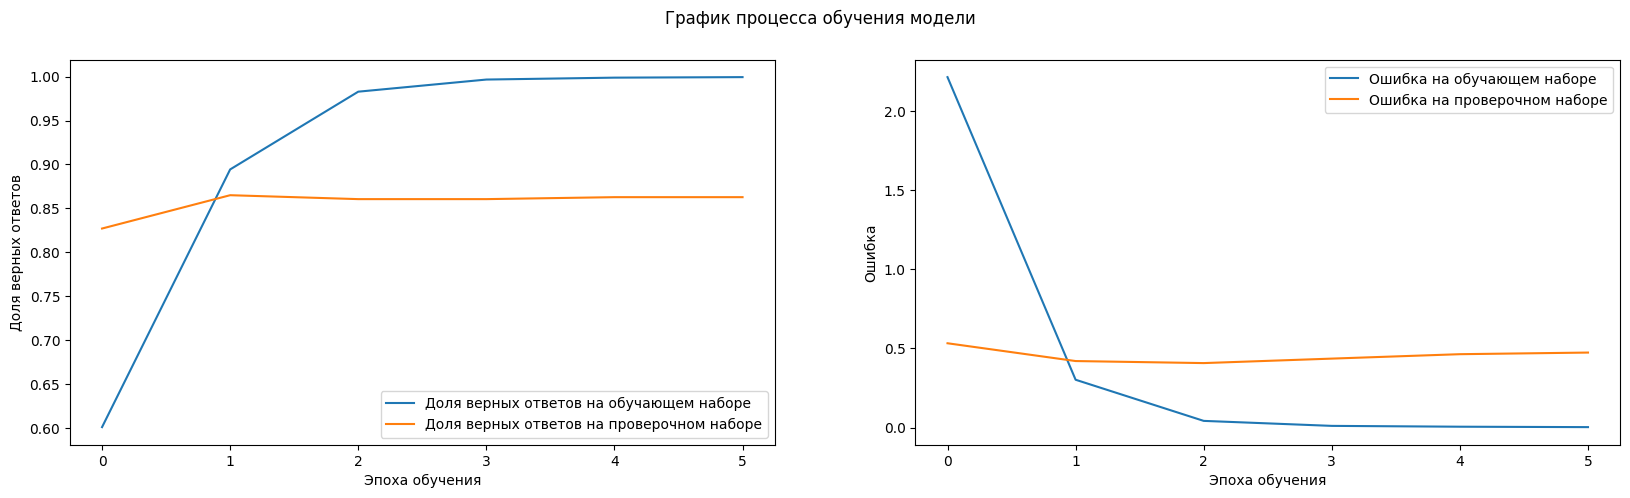

28/28 [==============================] - 2s 30ms/step


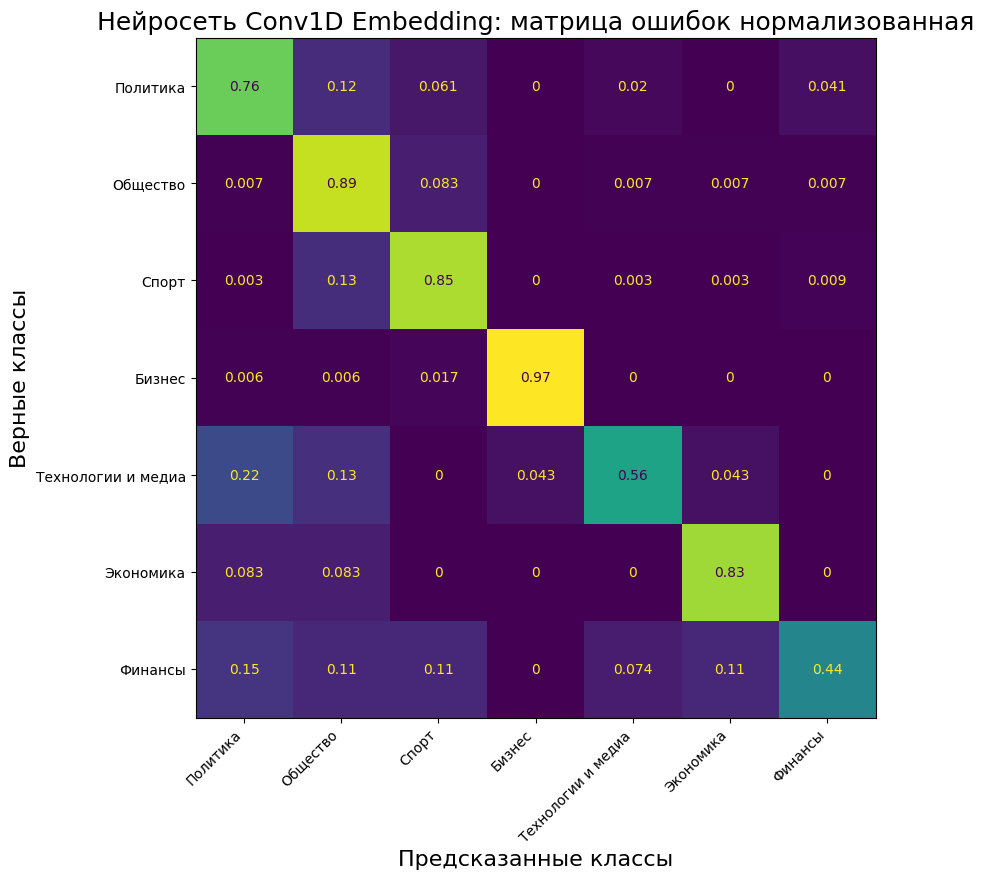

----------------------------------------------------------------------------------------------------
Нейросеть: Conv1D Embedding
Класс: Политика              76% сеть отнесла к классу Политика             - ВЕРНО :-)
Класс: Общество              89% сеть отнесла к классу Общество             - ВЕРНО :-)
Класс: Спорт                 85% сеть отнесла к классу Спорт                - ВЕРНО :-)
Класс: Бизнес                97% сеть отнесла к классу Бизнес               - ВЕРНО :-)
Класс: Технологии и медиа    56% сеть отнесла к классу Технологии и медиа   - ВЕРНО :-)
Класс: Экономика             83% сеть отнесла к классу Экономика            - ВЕРНО :-)
Класс: Финансы               44% сеть отнесла к классу Финансы              - ВЕРНО :-)

Средняя точность распознавания:  76%


In [42]:
model_conv1d_emb = Sequential()
model_conv1d_emb.add(Embedding(WIN_SIZE, 256, input_length=20000))
model_conv1d_emb.add(Conv1D(64, 3, activation='relu'))
model_conv1d_emb.add(Dropout(0.25))
model_conv1d_emb.add(Flatten())
model_conv1d_emb.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_conv1d_emb,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='Conv1D Embedding')

## Наилучшая - Simple BoW (точность 77%).

In [152]:
# Создание последовательной модели нейросети
model_best = Sequential()
model_best.add(Dense(200, input_dim=VOCAB_SIZE, activation="relu"))
model_best.add(Dropout(0.5))  # Увеличение коэффициента Dropout
model_best.add(BatchNormalization())
model_best.add(Dense(100, activation="relu"))
model_best.add(Dropout(0.5))  # Увеличение коэффициента Dropout
model_best.add(BatchNormalization())
model_best.add(Dense(50, activation="relu"))  # Добавление дополнительного скрытого слоя
model_best.add(Dense(CLASS_COUNT, activation='softmax'))

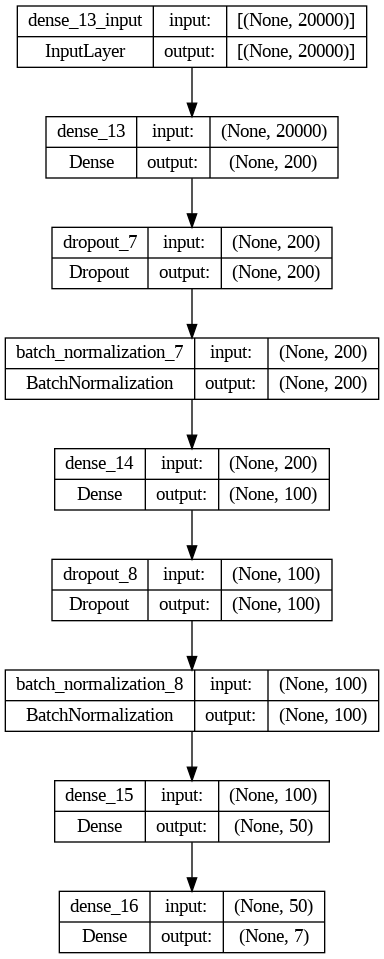

In [153]:
plot_model(model_best, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 200)               4000200   
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/40 [============================>.] - ETA: 0s - loss: 1.2425 - accuracy: 0.6428
Epoch 2: val_loss improved from 1.07852 to 0.71553, saving model to <keras.src.engine.sequential.Sequential object at 0x7cad9a440dc0>_weights.hdf5
40/40 [==============================] - 1s 22ms/step - loss: 1.2417 - accuracy: 0.6431 - val_loss: 0.7155 - val_accuracy: 0.8125
Epoch 3/30
39/40 [============================>.] - ETA: 0s - loss: 0.8530 - accuracy: 0.7712
Epoch 3: val_loss improved from 0.71553 to 0.50722, saving model to <keras.src.engine.sequential.Sequential object at 0x7cad9a440dc0>_weights.hdf5
40/40 [==============================] - 1s 27ms/step - loss: 0.8520 - accuracy: 0.7720 - val_loss: 0.5072 - val_accuracy: 0.8393
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.8505
Epoch 4: val_loss improved from 0.50722 to 0.42986, saving model to <keras.src.engine.sequential.Sequential object at 0x7cad9a440dc0>_weights.hdf5
40/40 [=====================

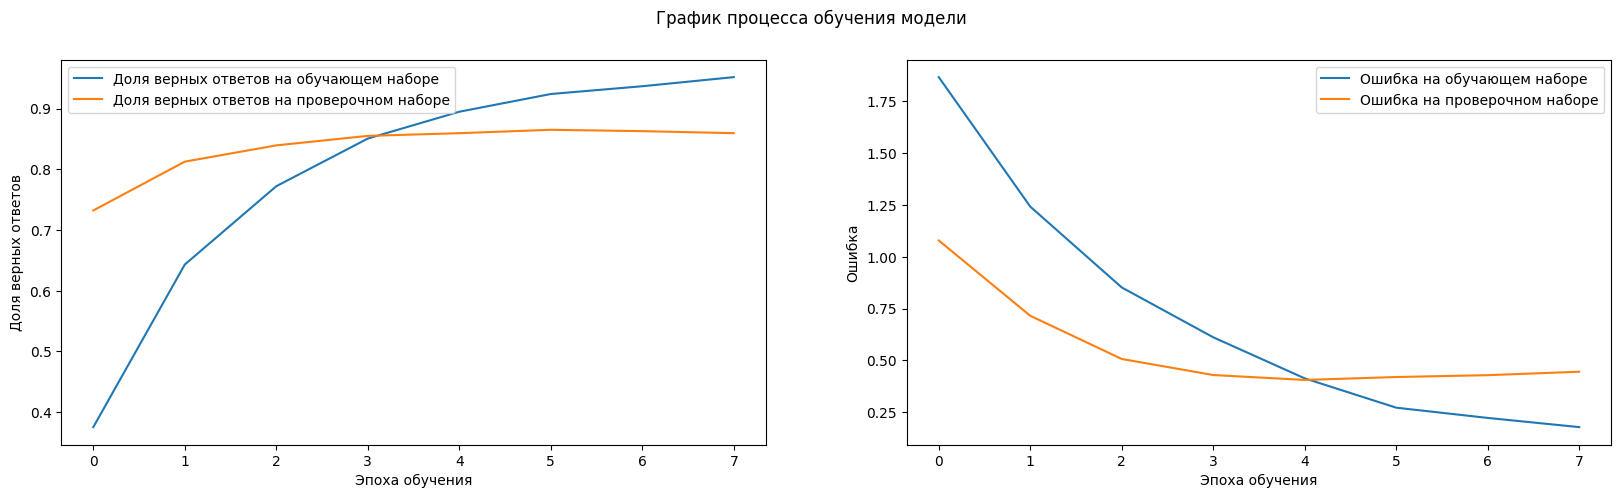

28/28 [==============================] - 0s 3ms/step


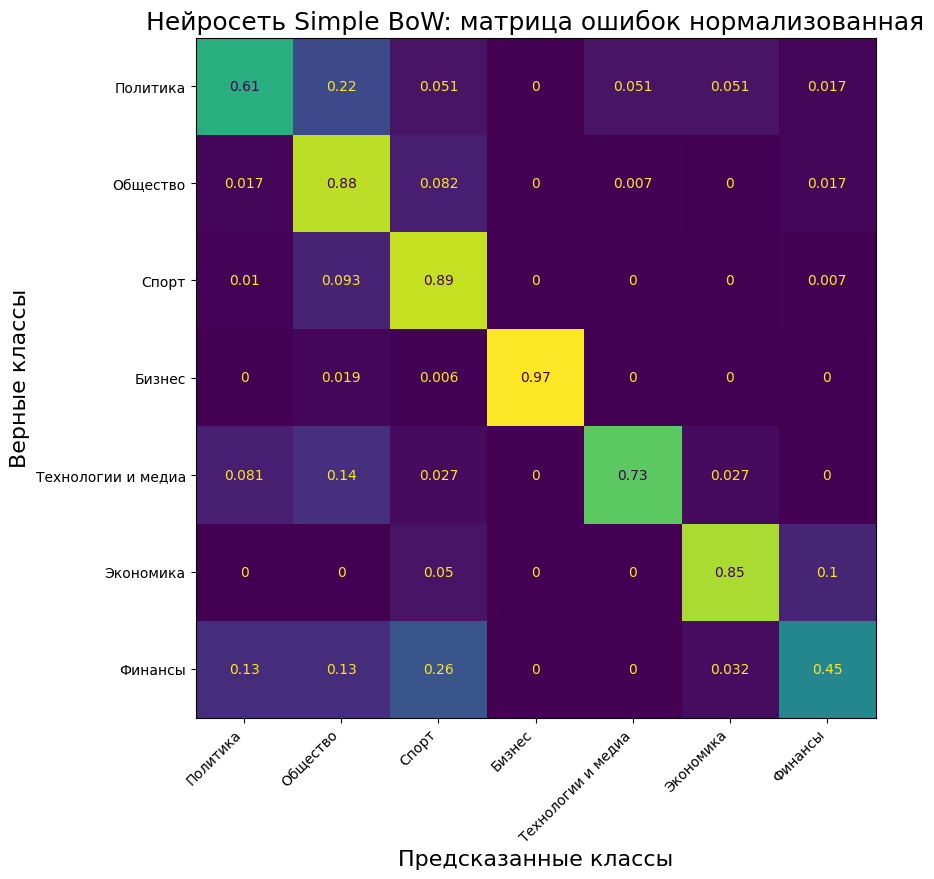

----------------------------------------------------------------------------------------------------
Нейросеть: Simple BoW
Класс: Политика              61% сеть отнесла к классу Политика             - ВЕРНО :-)
Класс: Общество              88% сеть отнесла к классу Общество             - ВЕРНО :-)
Класс: Спорт                 89% сеть отнесла к классу Спорт                - ВЕРНО :-)
Класс: Бизнес                98% сеть отнесла к классу Бизнес               - ВЕРНО :-)
Класс: Технологии и медиа    73% сеть отнесла к классу Технологии и медиа   - ВЕРНО :-)
Класс: Экономика             85% сеть отнесла к классу Экономика            - ВЕРНО :-)
Класс: Финансы               45% сеть отнесла к классу Финансы              - ВЕРНО :-)

Средняя точность распознавания:  77%


In [154]:
# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_best,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='Simple BoW')

Модель склонна к переобучению.

In [40]:
# with open('good.pkl', 'wb') as file:
#     pickle.dump((VOCAB_SIZE, len_max, CLASS_LIST, CLASS_COUNT), file)

In [164]:
  art = input()

  art = preprocess_text(art)
  art = tokenizer.texts_to_sequences([art])
  art = pad_sequences(art, maxlen=len_max)
  art = tokenizer.sequences_to_matrix(art.tolist())
  pred = model_best.predict(art)
  pred_class = CLASS_LIST[np.argmax(pred)]
  # return pred_class, np.argmax(pred)

print("Категория на предсказанной новости:", test_model(art))

Российская теннисистка Мирра Андреева пробилась в полуфинал «Ролан Гаррос», который проходит в Париже.  В четвертьфинале, который был для нее первым на турнирах «Большого шлема», 17-летняя россиянка победила вторую ракетку мира белоруску Арину Соболенко со счетом 6:7 (5:7), 6:4, 6:4. Матч продолжался два с половиной часа.  Андреева в возрасте 17 лет и 37 дней стала самой молодой участницей полуфиналов на турнире «Большого шлема» после Мартины Хингис, которая дошла до этой стадии в 16 лет на «Ролан Гаррос» и US Open в 1997 году.  Россиянка также стала самой молодой теннисисткой, обыгравшей на «Большом шлеме» соперницу из топ-2, с 1999 года, когда 16-летняя Елена Докич победила Хингис на Уимблдоне. Кроме того, Андреева самая молодая из тех, кто сделал это на «Ролан Гаррос», с 1990 года (после Моники Селеш, обыгравшей Штефи Граф в финале).  Белоруска испытывала проблемы со здоровьем на протяжении матча и обращалась за медицинской помощью.  Соболенко впервые проиграла на турнирах «Большого